# Cluster Analysis: Create, Visualize and Interpret Customer Segments

Este artículo lo guiará a través de todo el proceso de segmentación, desde el entendimiento de los datos, pasando por las buenas prácticas recomendadas para una correcta programación, el análisis exploratorio inicial, las transformaciones más adecuadas previas a la segmentación, así como la generación, análisis y visualización de los segmentos obtenidos mediante la exploración de características.


### (1) Carga de módulos necesarios

In [ ]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 4)
plt.style.use('ggplot')

In [ ]:
# Creando conexión con google drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### (2) Carga de datos y dimensionamiento

In [ ]:
#Cargando el dataset
data = pd.read_csv('/gdrive/My Drive/Colab Notebooks/datos/Mall_Customers.csv', sep=',',encoding = "ISO-8859-1") # desde drive personal

In [ ]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Dimensionamiento de variables

Como entendimiento de datos se tiene que conocer las dimensiones del DataFrame con que se está trabajando, es importante saber el número de observaciones con que se cuenta para analizar asi como el número de variables disponibles para el análsis

In [ ]:
print("Número de filas: " + str(data.shape[0]))
print("Número de columnas: " + str(data.shape[1]),'\n')
print('Tipo de variables:','\n', data.dtypes)
print('IDs únicos:', len(np.unique(data.CustomerID)))

Número de filas: 200
Número de columnas: 5 

Tipo de variables: 
 CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object
IDs únicos: 200


Como buenas prácticas es recomendable uniformizar los nombres de las variables para que el programa no tenga inconvenientes con las llamadas posteriores. Se recomienda trabajar sin espacios, sin caracteres especiales y conservando una estructura a nivel de palabras

In [ ]:
# Mostramos los nombres de variables originales
data.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [ ]:
# Renombrando las variables del DataFrame 
data.columns = ['CustomerID', 'Gender', 'Age', 'AnnualIncome','SpendingScore']
data.columns

Index(['CustomerID', 'Gender', 'Age', 'AnnualIncome', 'SpendingScore'], dtype='object')

Para un Análisis Exploratorio Inicial adecuado se separan los típos de variables en:
- Variables numéricas
- Variables categóricas

In [ ]:
# Se crean listas según el tipo de variable
string = ['Gender']
numeric = ['Age', 'AnnualIncome', 'SpendingScore']

### (3) Análisis Exploratorio de Datos


Variables numéricas

In [ ]:
# Anállisis descriptivo de variables
data[numeric].describe()

,Age,AnnualIncome,SpendingScore
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


El análisis descriptivo de variables numéricas muestra que existe disparidad entre los límites inferiores y superiores, es decir, las variables no están en las mismas dimensiones

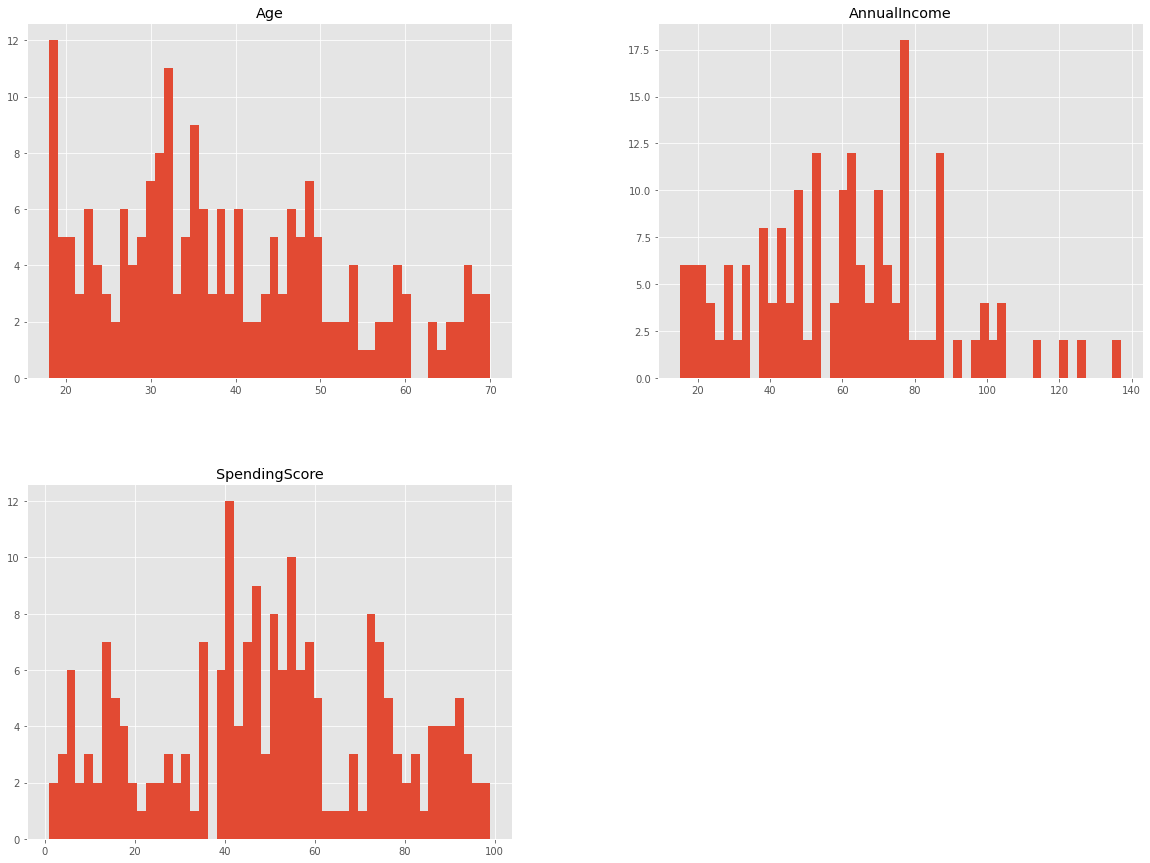

In [ ]:
# un análisis gráfico inicial
data[numeric].hist(bins = 50, figsize=(20,15))
plt.show()

Se realiza un poco de análisis bivariado en busca de variabilidad

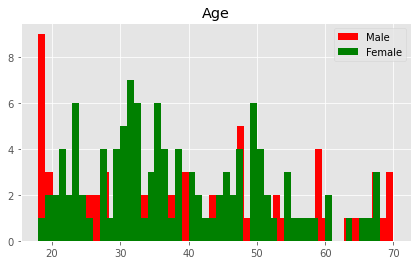

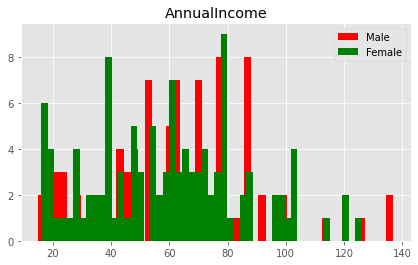

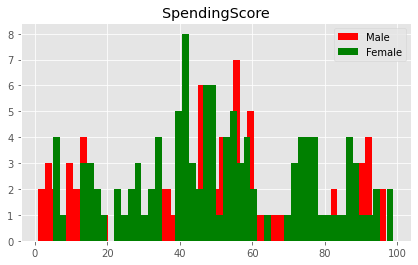

In [ ]:
for x in numeric:
  # Generamos los subsets de comparación
  x1 = data.loc[data.Gender =='Male', x]
  x2 = data.loc[data.Gender =='Female', x]
  # Mostramos las densidades
  plt.title(data[x].name)
  plt.hist(x1, bins= 50, color='r', label='Male')
  plt.hist(x2, bins= 50, color='g', label='Female')
  plt.legend()
  plt.show()

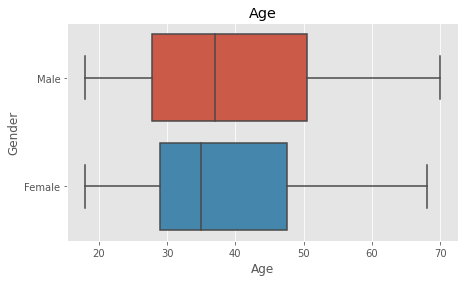

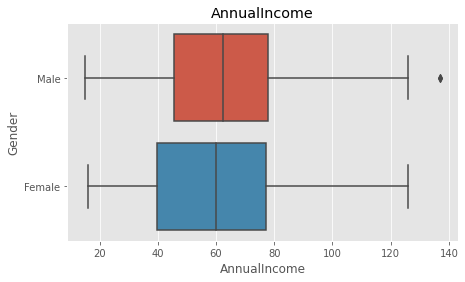

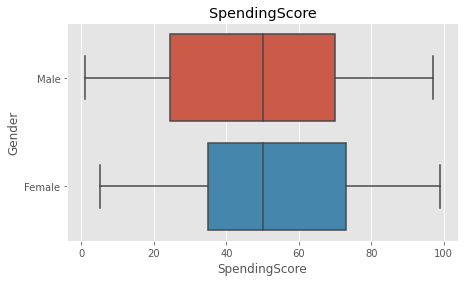

In [ ]:
for x in numeric:
  plt.title(data[x].name)
  sns.boxplot(x=data[x], y = data.Gender);
  plt.show()

Variables string

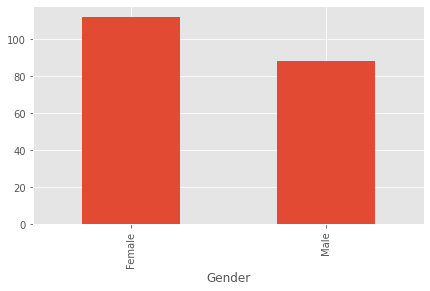

In [ ]:
# Análisis de frecuencias
data.fillna("--NULL").groupby('Gender')['Gender'].count().plot(kind = "bar")

Para tratar de encontrar las variables influyentes se busca de forma gráfica presencia de agrupaciones y dispersiones importantes. El cruce de las variables numéricas versus la variable categórica muestra que el género tiene mucha dispersión con respecto a las otras variables y no es influyente en el análisis; sin embargo, las variables AnnualIncome y SpendingScore muestran presencia de aglomeraciones por sectores indicando la posible división por segmentos.

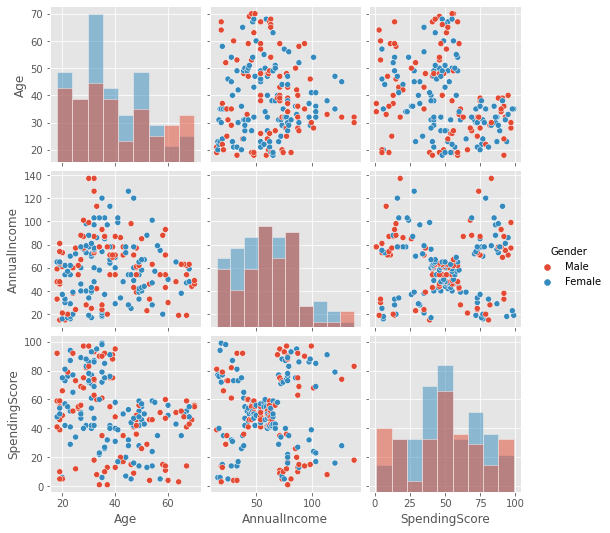

In [ ]:
# Buscamos relación entre variables
sns.pairplot(data.drop("CustomerID",axis=1), hue="Gender", diag_kind="hist")

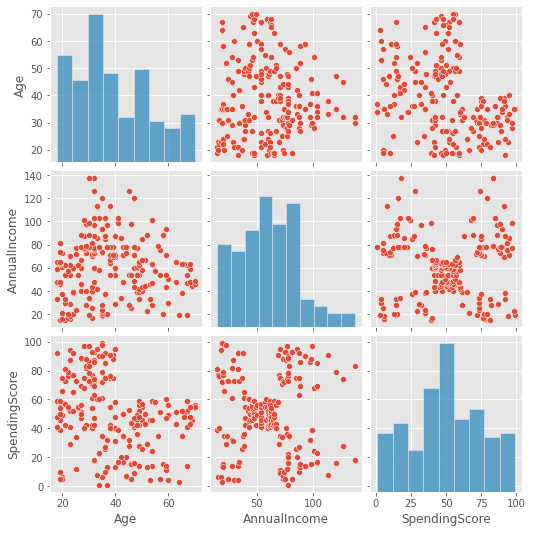

In [ ]:
# Buscamos relación entre variables
sns.pairplot(data.drop("CustomerID",axis=1), diag_kind="hist")

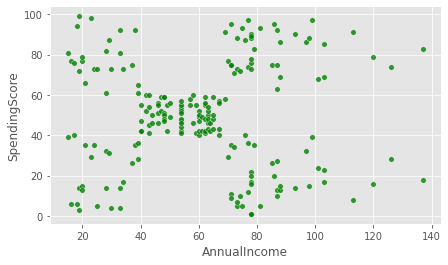

In [ ]:
# Se puede observar separaciones marcadas entre las variables AnnualIncome y SpendingScore
sns.scatterplot(x="AnnualIncome", y="SpendingScore", data=data, s=30, color="green", alpha = 0.8)

Del análisis descriptivo y visual inicial retiramos las variables que no aportan a nuestro análisis: CustomerID y Género y creamos un nuevo DataFrame de nombre df quedándonos únicamente con las variables importantes

In [ ]:
# Retiramos las variables que no aportan
df = data.drop(["CustomerID","Gender"],axis=1)

In [ ]:
df.head(5)

,Age,AnnualIncome,SpendingScore
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


Transformamos nuestros datos para lograr una correcta lectura de los algoritmos

Algo para considerar en el modelo de análisis de segmentación es que los algorítmos generalmente utilizan la distancia euclideana para calculas las distancias, sin embargo, esta distancia falla cuando se tiene datos en diferentes dimensiones. Una solución es utilizar la distancia coseno, que funciona mejor para datos en diferentes dimensiones, y dado que la distancia coseno y la distancia euclidiana están conectadas linealmente para los vectores normalizados, simplemente podemos normalizar nuestros datos.

In [ ]:
from sklearn import preprocessing
# scaler = preprocessing.StandardScaler()

In [ ]:
# escalado de datos
normalized_vectors = preprocessing.normalize(df)
normalized_vectors

array([[0.41392469, 0.32678265, 0.84963489],
       [0.24702464, 0.17644617, 0.95280931],
       [0.76028592, 0.60822874, 0.22808578],
       [0.28069661, 0.19526721, 0.93972343],
       [0.5806832 , 0.31843918, 0.74926865],
       [0.27185366, 0.21006874, 0.93913083],
       [0.87913063, 0.45212432, 0.15070811],
       [0.23366214, 0.18286603, 0.95496702],
       [0.95768043, 0.28431138, 0.04489127],
       [0.37368855, 0.23666942, 0.89685253],
       [0.94319433, 0.26747302, 0.19708538],
       [0.3279921 , 0.17805285, 0.92774908],
       [0.91832409, 0.31666348, 0.23749761],
       [0.28882142, 0.24068452, 0.92663539],
       [0.84047507, 0.45431085, 0.29530205],
       [0.26063351, 0.23693955, 0.93591123],
       [0.65094455, 0.39056673, 0.65094455],
       [0.27743014, 0.29130164, 0.91551945],
       [0.81469084, 0.36034402, 0.45434681],
       [0.32841056, 0.21581265, 0.91954957],
       [0.63625848, 0.43629153, 0.63625848],
       [0.30937372, 0.29699877, 0.90337126],
       [0.

### (4) Algoritmos de clustering

Existen muchos algoritmos no supervisados de segmentación, cada uno tiene fortalezas significativas en ciertas situaciones, a continuación se discutirán los más utilizados.

#### 4.1. Segmentación Kmeans

Este es uno de los algoritmos más utilizados para agrupar datos. k-Means comienza eligiendo k centros aleatorios que pueden ser establecidos de manera manual. Luego, todos los puntos de datos se asignan al centro más cercano en función de su distancia. A continuación, se calculan los nuevos centros y se actualizan los puntos de datos. Este proceso es continuo hasta que los grupos no cambian entre iteraciones.

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [ ]:
# Seleccionando nuestro set de datos
X = normalized_vectors
X

array([[0.41392469, 0.32678265, 0.84963489],
       [0.24702464, 0.17644617, 0.95280931],
       [0.76028592, 0.60822874, 0.22808578],
       [0.28069661, 0.19526721, 0.93972343],
       [0.5806832 , 0.31843918, 0.74926865],
       [0.27185366, 0.21006874, 0.93913083],
       [0.87913063, 0.45212432, 0.15070811],
       [0.23366214, 0.18286603, 0.95496702],
       [0.95768043, 0.28431138, 0.04489127],
       [0.37368855, 0.23666942, 0.89685253],
       [0.94319433, 0.26747302, 0.19708538],
       [0.3279921 , 0.17805285, 0.92774908],
       [0.91832409, 0.31666348, 0.23749761],
       [0.28882142, 0.24068452, 0.92663539],
       [0.84047507, 0.45431085, 0.29530205],
       [0.26063351, 0.23693955, 0.93591123],
       [0.65094455, 0.39056673, 0.65094455],
       [0.27743014, 0.29130164, 0.91551945],
       [0.81469084, 0.36034402, 0.45434681],
       [0.32841056, 0.21581265, 0.91954957],
       [0.63625848, 0.43629153, 0.63625848],
       [0.30937372, 0.29699877, 0.90337126],
       [0.

Parra determinar el número de clústeres óptimos se suele utilizar el método del codo. Puede hacerse este gráfico sorteando un número secuencial de grupos en el eje X y la inercia (criterio de suma de cuadrados dentro del grupo) en el eje Y.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Inercia de k-Means versus número de clusters')

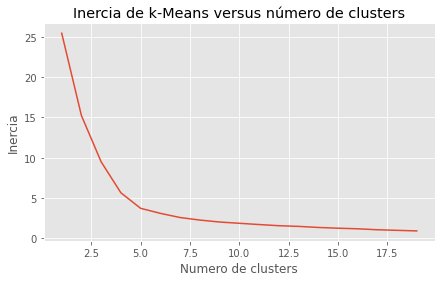

In [ ]:
# Calculando el número de clúster adecuado:
scores = [KMeans(n_clusters=i).fit(X).inertia_ for i in range(1,20)]
sns.lineplot(np.arange(1, 20), scores)
plt.xlabel('Numero de clusters')
plt.ylabel("Inercia")
plt.title("Inercia de k-Means versus número de clusters")

In [ ]:
# Obtenemos los indicadores de clustering:
for i in range(2,10):
  kmeans = KMeans(n_clusters= i)
  kmeans.fit(X)
  cluster = kmeans.predict(X)
  print('cluster con',i,'segmentos')
  print('Inercia: '+str(kmeans.inertia_)) 
  #print('Silueta: '+str(metrics.silhouette_score(X, cluster, metric='euclidean')))
  print('Silueta: '+str(metrics.silhouette_score(X, cluster, metric='cosine')))
  print('\n')

cluster con 2 segmentos
Inercia: 15.229102197847826
Silueta: 0.5172637046312352


cluster con 3 segmentos
Inercia: 9.481729149066103
Silueta: 0.6172775543266965


cluster con 4 segmentos
Inercia: 5.638812950147302
Silueta: 0.6851204429695915


cluster con 5 segmentos
Inercia: 3.7088709324877547
Silueta: 0.7325190099726094


cluster con 6 segmentos
Inercia: 3.0830602379129877
Silueta: 0.6659204742587229


cluster con 7 segmentos
Inercia: 2.5637003665391402
Silueta: 0.6390664834449737


cluster con 8 segmentos
Inercia: 2.2443920896829743
Silueta: 0.6026002264310154


cluster con 9 segmentos
Inercia: 2.0479470229845735
Silueta: 0.5762580788933473




Los indicadores de inercia y silueta indican que el número optimo de clusters es de 5, así que se procede a generar el cluster final en base a 5 segmentos

In [ ]:
# Número optimo de clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
cluster = kmeans.predict(X)
cluster[:20]

array([1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3, 1, 2, 1],
      dtype=int32)

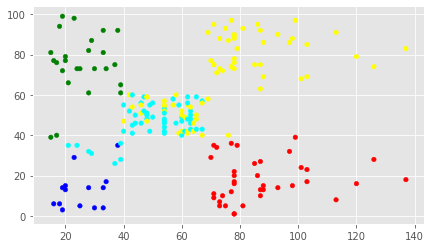

In [ ]:
# Graficamos nuestro cluster
fig = plt.figure()
f1 = data['AnnualIncome'].values
f2 = data['SpendingScore'].values

colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in cluster:
    asignar.append(colores[row])
    
plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

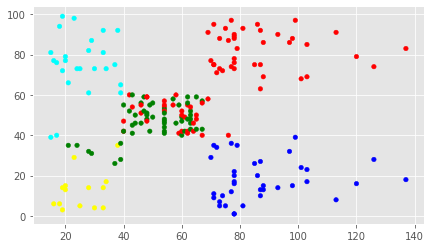

In [ ]:
# Graficamos nuestro cluster
fig = plt.figure()
f1 = data['AnnualIncome'].values
f2 = data['SpendingScore'].values

colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in cluster:
    asignar.append(colores[row])
    
plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

Finalmente añadimos la variable cluster a nuestro set de datos original

In [ ]:
# Cargamos la variable cluster en nuestro set de datos
data['k_means'] = cluster
data.groupby('k_means').size()/data.shape[0]

k_means
0    0.185
1    0.125
2    0.070
3    0.265
4    0.355
dtype: float64

Text(0.5, 1.0, 'Cluster kmeans')

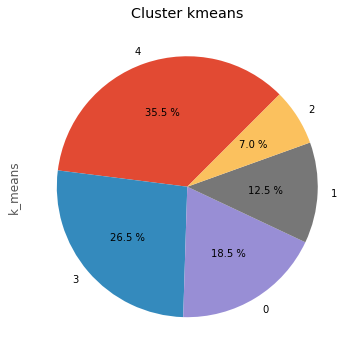

In [ ]:
# Graficamos va variable cluster generada
ax = data.k_means.value_counts().plot.pie(startangle=45,
                                     autopct='%.1f %%',
                                     figsize=(8, 6))
ax.set_title("Cluster kmeans")

#### 4.2. Segmentación DB SCAN

La agrupación espacial basada en densidad de aplicaciones con ruido (DBCSAN) es un algoritmo de agrupación que se propuso en 1996. DBSCAN es un método de agrupación en clústeres que se utiliza en el aprendizaje automático para separar clústeres de alta densidad de clústeres de baja densidad. Dado que DBSCAN es un algoritmo de agrupamiento basado en densidad, hace un gran trabajo al buscar áreas en los datos que tienen una alta densidad de observaciones, frente a áreas de los datos que no son muy densas con observaciones. DBSCAN también puede clasificar datos en grupos de diferentes formas.

In [ ]:
# Cargamos los paquetes necesarios
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [ ]:
X

array([[0.41392469, 0.32678265, 0.84963489],
       [0.24702464, 0.17644617, 0.95280931],
       [0.76028592, 0.60822874, 0.22808578],
       [0.28069661, 0.19526721, 0.93972343],
       [0.5806832 , 0.31843918, 0.74926865],
       [0.27185366, 0.21006874, 0.93913083],
       [0.87913063, 0.45212432, 0.15070811],
       [0.23366214, 0.18286603, 0.95496702],
       [0.95768043, 0.28431138, 0.04489127],
       [0.37368855, 0.23666942, 0.89685253],
       [0.94319433, 0.26747302, 0.19708538],
       [0.3279921 , 0.17805285, 0.92774908],
       [0.91832409, 0.31666348, 0.23749761],
       [0.28882142, 0.24068452, 0.92663539],
       [0.84047507, 0.45431085, 0.29530205],
       [0.26063351, 0.23693955, 0.93591123],
       [0.65094455, 0.39056673, 0.65094455],
       [0.27743014, 0.29130164, 0.91551945],
       [0.81469084, 0.36034402, 0.45434681],
       [0.32841056, 0.21581265, 0.91954957],
       [0.63625848, 0.43629153, 0.63625848],
       [0.30937372, 0.29699877, 0.90337126],
       [0.

La diferencia con k-means es que DBSCAN no requiere que especifique el número de clústeres. Los dos parámetros principales para DBSCAN son el número mínimo de puntos que constituyen un grupo (minPts) y el tamaño de la vecindad (eps). Por lo general, el número de puntos que constituyen un punto no debe ser muy pequeño, ya que se puede generar errores en los grupos. Como regla general, se aconseja establecer el número de minPts en la misma cantidad de características que los datos. eps es un poco más difícil de optimizar y podría requerir un gráfico de distancia k para encontrar el valor correcto. A menudo se prefiere utilizar valores pequeños iterando buscando eficiencias.

En términos sencillos, encontramos un valor adecuado para épsilon calculando la distancia a los n puntos más cercanos para cada punto, ordenando y trazando los resultados. Luego miramos para ver dónde el cambio es más pronunciado

In [ ]:
from sklearn.neighbors import NearestNeighbors

Podemos calcular la distancia desde cada punto hasta su vecino más cercano usando NeighborsNeighbors. El punto en sí está incluido en n_neighbors. El método kneighbors devuelve dos matrices, una que contiene la distancia a los n_neighbors puntos más cercanos y la otra que contiene el índice para cada uno de esos puntos.

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

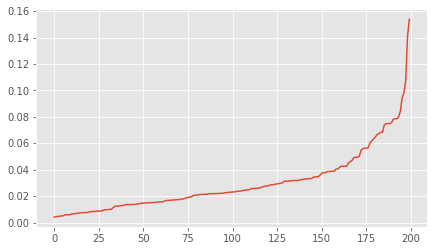

In [ ]:
# Clasificamos y representamos los resultados.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

El valor óptimo de épsilon es 0.08 que se encontra en el punto de máxima curvatura.

In [ ]:
# Creando algoritmo DBSCAN
dbscan = DBSCAN(eps = 0.08,min_samples=4)
model_dbscan = dbscan.fit(X)
labels = model_dbscan.labels_
labels

array([ 0,  0, -1,  0, -1,  0,  2,  0, -1,  0, -1,  0, -1,  0, -1,  0,  1,
        0, -1,  0,  1,  0,  2,  0, -1,  0,  1, -1,  1,  0,  2,  0,  2,  0,
       -1,  0, -1, -1,  1,  0, -1,  0,  1, -1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  3,  1, -1,  1, -1,  1,  3,  1, -1,  1,  3,  1,
        3,  1,  3,  1, -1,  1, -1,  1,  3,  1, -1,  1,  3,  1,  3,  1,  3,
        1,  3,  1, -1,  1, -1,  1, -1,  1,  3,  1,  3,  1,  3,  1,  3,  1,
        3,  1,  3,  1,  3,  1,  3,  1,  3,  1,  3,  1,  3,  1,  3,  1,  3,
        1,  3,  1,  3,  1,  3,  1,  3,  1,  3,  1,  3,  1])

In [ ]:
# Mostramos los clusters generados
print("clusters: ", np.unique(labels))
print("nro de clusters:",len(np.unique(labels)) -1)
print('Silueta: '+str(metrics.silhouette_score(df, model_dbscan.labels_, metric='cosine')))

clusters:  [-1  0  1  2  3]
nro de clusters: 4
Silueta: 0.4677741046219577


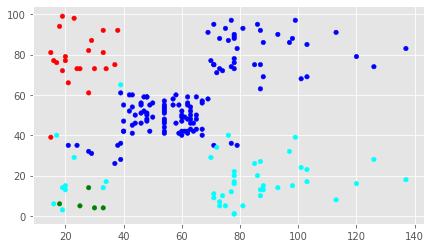

In [ ]:
# Graficamos nuestro cluster
fig = plt.figure()
f1 = data['AnnualIncome'].values
f2 = data['SpendingScore'].values
 
colores=['red','green','blue','cyan']
asignar=[]
for row in labels:
    asignar.append(colores[row])
    
plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

In [ ]:
# Cargamos la variable cluster en nuestro set de datos
data['dbscan'] = labels
data.groupby('dbscan').size()/data.shape[0]

dbscan
-1    0.120
 0    0.100
 1    0.615
 2    0.020
 3    0.145
dtype: float64

Text(0.5, 1.0, 'Cluster dbscan')

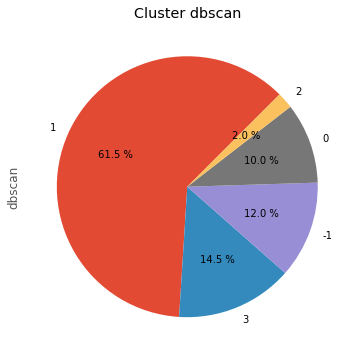

In [ ]:
# Graficamos va variable cluster generada
ax = data.dbscan.value_counts().plot.pie(startangle=45,
                                     autopct='%.1f %%',
                                     figsize=(8, 6))
ax.set_title("Cluster dbscan")

#### 4.3. Segmentación Jerárquica

La agrupación jerárquica es una alternativa a los algoritmos de agrupación basados en prototipos. La principal ventaja de la agrupación jerárquica es que tampoco se necesita especificar el número de agrupaciones. Además, permite el trazado de dendogramas. Los dendogramas son visualizaciones de una agrupación jerárquica binaria.

In [ ]:
# Creamos el dendograma para encontrar el número óptimo de clusters
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

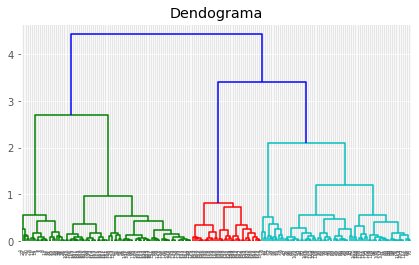

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendograma')
plt.show()

Al marcar con una linea imaginaria en el dendograma cogiendo todos los clusters formados por la linea azul, observamos que se genera 5 clusters.

In [ ]:
# Ajustando Clustering Jerárquico al conjunto de datos
jerarquico = AgglomerativeClustering(n_clusters = 5, 
                    affinity = 'euclidean', 
                    linkage = 'ward')

clust_j = jerarquico.fit_predict(X)

In [ ]:
clust_j

array([3, 3, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 0, 3, 0, 3, 0, 3,
       4, 3, 4, 3, 0, 3, 0, 3, 4, 3, 4, 3, 4, 3, 4, 3, 0, 3, 0, 3, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 1, 0, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1])

In [ ]:
# Analizando el indicador de silueta
print('Silueta: '+str(metrics.silhouette_score(df, clust_j, metric='cosine')))

Silueta: 0.7033534397592506


In [ ]:
# Cargamos la variable cluster en nuestro set de datos
data['k_jerarquico'] = clust_j
data.groupby('k_jerarquico').size()/data.shape[0]

k_jerarquico
0    0.325
1    0.325
2    0.175
3    0.115
4    0.060
dtype: float64

Text(0.5, 1.0, 'Cluster jerarquico')

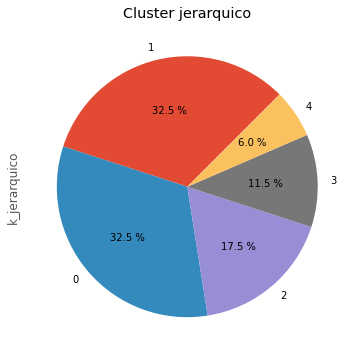

In [ ]:
# Graficamos va variable cluster generada
ax = data.k_jerarquico.value_counts().plot.pie(startangle=45,
                                     autopct='%.1f %%',
                                     figsize=(8, 6))
ax.set_title("Cluster jerarquico")

#### 4.4. Comparación final de metodologías

In [ ]:
print('Comparando metodologías:','\n')
print('Silueta kmeans: '+str(metrics.silhouette_score(df, cluster, metric='cosine')))
print('Silueta DBSCAN: '+str(metrics.silhouette_score(df, model_dbscan.labels_, metric='cosine')))
print('Silueta Jerarquico: '+str(metrics.silhouette_score(df, clust_j, metric='cosine')))

Comparando metodologías: 

Silueta kmeans: 0.7325190099726087
Silueta DBSCAN: 0.4677741046219577
Silueta Jerarquico: 0.7033534397592506
